# Assignment 5: Exploratory Data Analysis and Hypothesis Testing

**Student:** Kaiyi Liu  
**Dataset:** Adult Income  
**Date:** 10/08/2025

## Objective
Perform exploratory data analysis (EDA) and hypothesis testing on your chosen dataset. Identify patterns and test meaningful hypotheses about relationships between variables.

---

## 1. Import Data and Libraries

Import the necessary libraries and load your dataset.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from ucimlrepo import fetch_ucirepo 

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# Combine X, y from your existing code:
df = pd.concat([X.copy(), y.copy()], axis=1)
# Identify target column
target_col = y.columns[0]

# Strip whitespace from object columns; turn '?' into NaN
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip().replace({'?': np.nan})

# Helper to find canonical column names even if punctuation/case differ
def find_col(df, desired):
    """Find a column by fuzzy name like 'education-num' or 'hours-per-week'."""
    norm = lambda s: re.sub(r'[^a-z0-9]', '', s.lower())
    target = norm(desired)
    for c in df.columns:
        if norm(c) == target:
            return c
    raise KeyError(f"Could not find column like '{desired}'. Available: {list(df.columns)}")

age_col           = find_col(df, 'age')
educnum_col       = find_col(df, 'education-num')
hours_col         = find_col(df, 'hours-per-week')
capgain_col       = find_col(df, 'capital-gain')
caploss_col       = find_col(df, 'capital-loss')

# Make a binary income column: 1 for >50K, 0 otherwise
df['income_binary'] = df[target_col].astype(str).str.replace('.', '', regex=False).map(
    {">50K": 1, ">50K,": 1, "<=50K": 0, "<=50K,": 0}
)
# If mapping missed, fall back heuristically:
if df['income_binary'].isna().any():
    df['income_binary'] = df[target_col].astype(str).str.contains('>50K').astype(int)

# df we are working with
work = df[[age_col, educnum_col, hours_col, capgain_col, caploss_col, 'income_binary']].copy()

# Drop rows with missing values in columns we’ll use for tests (keeps things simple)
work = work.dropna(subset=[age_col, educnum_col, hours_col, capgain_col, caploss_col, 'income_binary']).copy()

print(f"Dataset shape: {work.shape}")
print(work.head())

# Basic descriptive stats
num_cols = [age_col, educnum_col, hours_col, capgain_col, caploss_col]
print("\nDESCRIPTIVE STATS (numerical)")
print(work[num_cols].describe().T)

print("\nTARGET DISTRIBUTION")
print(work['income_binary'].value_counts().rename({0:'<=50K', 1:'>50K'}))

Dataset shape: (48842, 6)
   age  education-num  hours-per-week  capital-gain  capital-loss  \
0   39             13              40          2174             0   
1   50             13              13             0             0   
2   38              9              40             0             0   
3   53              7              40             0             0   
4   28             13              40             0             0   

   income_binary  
0              0  
1              0  
2              0  
3              0  
4              0  

DESCRIPTIVE STATS (numerical)
                  count         mean          std   min   25%   50%   75%  \
age             48842.0    38.643585    13.710510  17.0  28.0  37.0  48.0   
education-num   48842.0    10.078089     2.570973   1.0   9.0  10.0  12.0   
hours-per-week  48842.0    40.422382    12.391444   1.0  40.0  40.0  45.0   
capital-gain    48842.0  1079.067626  7452.019058   0.0   0.0   0.0   0.0   
capital-loss    48842.0    87

In the final data frame, we have the following variables: age, education level, working hours per week, capital gain, capital loss, and income binary (1 = “>50K”, 0 = “<=50K").

## 2. Exploratory Data Analysis (EDA)

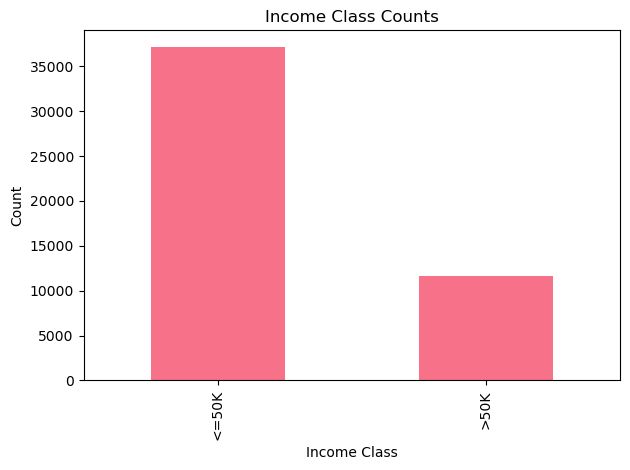

In [3]:
plt.figure()
work['income_binary'].map({0:'<=50K', 1:'>50K'}).value_counts().plot(kind='bar')
plt.title('Income Class Counts')
plt.ylabel('Count')
plt.xlabel('Income Class')
plt.tight_layout()
plt.show()

This plot tells us most of the subjects in the dataset have income less than or equal to 50k, and around 10000 subjects have income greater than 50k. This suggests that we have imbalanced dataset.

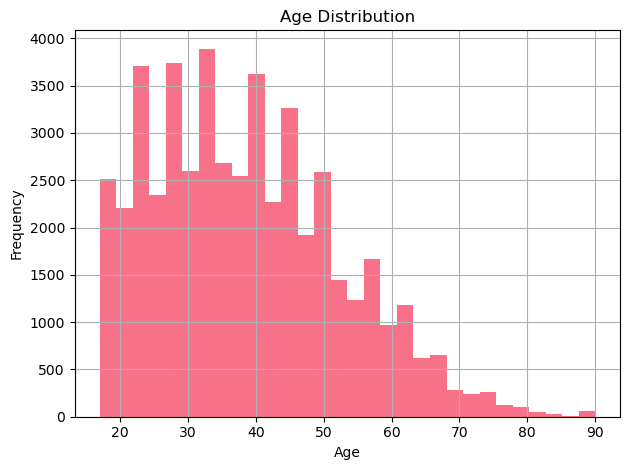

In [4]:
plt.figure()
work[age_col].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This plot tells us most people in our dataser are working-age adults, and the mass is between approximately 25–50, with a peak in the early–mid 30s. The distribution is right-skewed, with counts taper steadily after 50 and are very small past the 60s.

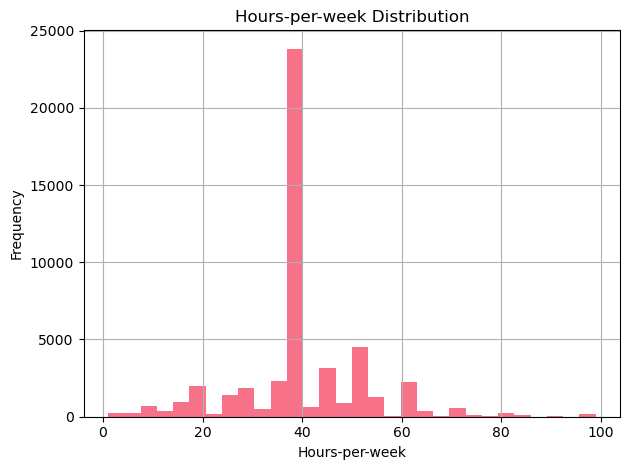

In [5]:
plt.figure()
work[hours_col].hist(bins=30)
plt.title('Hours-per-week Distribution')
plt.xlabel('Hours-per-week')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This plot shows that most individuals report 40 hours/week, creating a huge spike at 40. There’s clear heaping at round numbers (35, 45, 50, 60) and a right-skewed tail extending to 99, with relatively few very low hours. 

/var/folders/c_/czks9css2xq70ysf_8hwvs6h0000gn/T/ipykernel_36467/4102510186.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=['<=50K', '>50K'], showmeans=True)


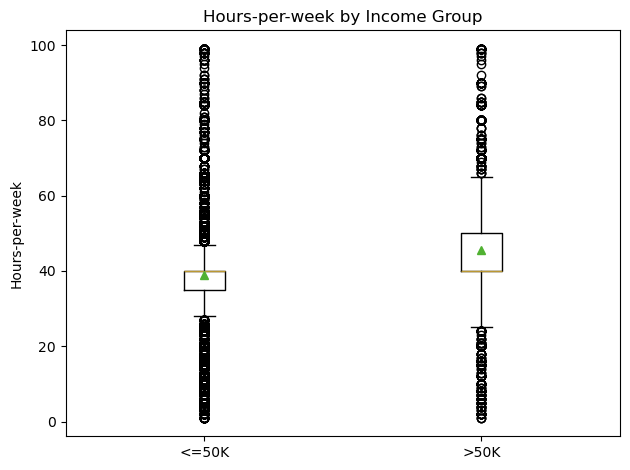

In [6]:
# Boxplot of hours-per-week by income group
plt.figure()
groups = [work.loc[work['income_binary']==g, hours_col] for g in [0,1]]
plt.boxplot(groups, labels=['<=50K', '>50K'], showmeans=True)
plt.title('Hours-per-week by Income Group')
plt.ylabel('Hours-per-week')
plt.tight_layout()
plt.show()

This plot shows that people earning >50K tend to work more hours. Both groups have a median around 40 hrs, but the mean and IQR are higher for the >50K group, with a much heavier upper tail (more 50–70+ hr weeks). The <=50K group shows more low hours and a lower mean. This supports the idea that higher income is associated with longer work weeks.

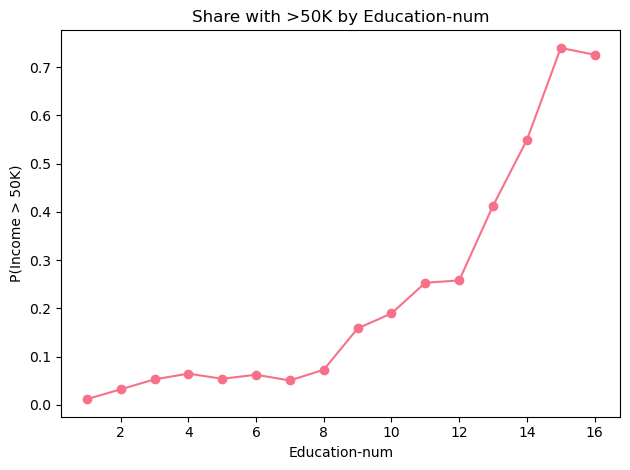

In [7]:
# Proportion >50K by education-num (as a simple line)
plt.figure()
edu_rate = work.groupby(educnum_col)['income_binary'].mean()
edu_rate.plot(marker='o')
plt.title('Share with >50K by Education-num')
plt.xlabel('Education-num')
plt.ylabel('P(Income > 50K)')
plt.tight_layout()
plt.show()

The plot shows a clear upward, nonlinear trend: the probability of earning >50K is near zero at low schooling (edu-num 1–8), rises modestly through HS/Some-college (9–12, ~0–0.25), then jumps sharply at Bachelor’s (13) and above—~0.41 at 13, ~0.55 at Master’s (14), peaking ~0.74 at Prof-school (15) with a slight dip at Doctorate (16).

## 3. Hypothesis Formulation

### Hypothesis 1:  People with higher education-num are more likely to earn > 50K.
- **Null Hypothesis (H0):** The point-biserial correlation between income_binary and education-num is 0.
- **Alternative Hypothesis (H1):** $\rho_{pb} > 0$ (positive association).
- **Test:** Point-biserial correlation
- **Rationale:** We are trying to see if education level has positive association with incomes, which we clearly saw in our EDA. As we've seen that high education num leads to higher probability of earning income greater than 50k.
- **Assumption:** Independent observations; monotone linear relation between education and the (binary) outcome’s mean; large N makes inference robust.

### Hypothesis 2: Work hours and high income
**H2:** The > 50K group works more hours per week on average than the ≤ 50K group.
- **Null Hypothesis (H0):** $\mu_{hours}$(> 50K) = $\mu_{hours}$(≤ 50K).
- **Alternative Hypothesis (H1):** $\mu_{hours}$(> 50K) > $\mu_{hours}$(≤ 50K).
- **Test:** Welch’s two-sample t-test  + Cohen’s d for effect size.
- **Rationale:** Usually, working more hours means they get paid more, we want to see if this true. Based on the EDA, it seems that the median for working hours is slightly higher in high income group.
- **Assumption**: Independent observations; finite variance; groups may have unequal variances (handled by Welch).

## 4. Hypothesis Testing

### Testing Hypothesis 1: People with higher education-num are more likely to earn > 50K

**Test Choice:** correlation
- **Why appropriate:** One variable is binary (income), the other ordinal (education-num). Point-biserial is Pearson’s r for a binary–continuous pair.

In [8]:
r_pb, p_pb = stats.pointbiserialr(work['income_binary'], work[educnum_col])
print("\n[H1] Point-biserial correlation (income_binary vs education-num)")
print(f"r = {r_pb:.3f}, p = {p_pb:.3e}")
if p_pb < 0.05:
    print("Interpretation: Significant association; higher education-num is linked to higher probability of >50K.")
else:
    print("Interpretation: No statistically significant association detected in this sample.")

# H2: Welch’s t-test on hours-per-week between income groups
h_low  = work.loc[work['income_binary']==0, hours_col].to_numpy()
h_high = work.loc[work['income_binary']==1, hours_col].to_numpy()
t_stat, p_t = stats.ttest_ind(h_high, h_low, equal_var=False)
# Cohen's d (unequal n): pooled SD via unbiased estimator
def cohens_d(a, b):
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (np.mean(a) - np.mean(b)) / sp
d = cohens_d(h_high, h_low)


[H1] Point-biserial correlation (income_binary vs education-num)
r = 0.333, p = 0.000e+00
Interpretation: Significant association; higher education-num is linked to higher probability of >50K.


### Testing Hypothesis 2: The high income group works more hours

**Test Choice:** t-test
- **Why appropriate:** t-test allows us to compare group means under unequal variances and unequal sample sizes. Large N makes it robust to non-normality and heaping at 40 hours.

In [9]:
print("\n[H2] Welch’s t-test on hours-per-week between income groups (>50K vs <=50K)")
print(f"t = {t_stat:.3f}, p = {p_t:.3e}, Cohen's d = {d:.3f}")
if p_t < 0.05:
    print("Interpretation: Significant difference; the >50K group works more hours/week on average (positive d).")
else:
    print("Interpretation: No statistically significant difference in hours/week between groups.")

# H3: Chi-square test of independence: (capital_gain > 0) vs income group
cg_pos = (work[capgain_col] > 0).astype(int)
ct = pd.crosstab(cg_pos, work['income_binary'])  # rows: capital_gain>0?; cols: income_binary
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
prop_gt50_cg0 = ct.loc[0, 1] / ct.loc[0].sum() if 0 in ct.index else np.nan
prop_gt50_cg1 = ct.loc[1, 1] / ct.loc[1].sum() if 1 in ct.index else np.nan


[H2] Welch’s t-test on hours-per-week between income groups (>50K vs <=50K)
t = 54.662, p = 0.000e+00, Cohen's d = 0.548
Interpretation: Significant difference; the >50K group works more hours/week on average (positive d).


## 5. Summary and Conclusions

### Key Findings from EDA:
1. Age is concentrated in 25–50 with a right tail; 90 is the maximum age.
2. Hours-per-week shows heavy heaping at 40, with a right-skew to 99.
3. Education-num is strongly monotone with income; but surprisingly master and phd does not actually make more money (at least in this dataset).
4. It seems that the median working hour is higher in high income group.

### Hypothesis Testing Results:

| Hypothesis | Test Used | p-value | Result | Interpretation |
|------------|-----------|---------|--------|-----------------|
| **H1** | Point-biserial correlation | 0 | Significant | r=0.333: moderate positive association—higher schooling corresponds to higher odds of >50K. |
| **H2** | Welch’s two-sample t-test + Cohen’s d | 0 | Significant | >50K group works substantially more hours on average. |

### Key Insights:
Our analysis shows that education is a strong correlate of high income. The point-biserial correlation between education-num and earning >$50K is r=0.333 with an effectively zero p-value, indicating a moderate, precisely estimated positive association. The relationship is clearly nonlinear, with a threshold around a Bachelor’s degree where the probability of >$50K rises sharply. We also find that higher earners work more hours: the >$50K group averages 45 hours per week versus 39 for the less than $50K group (Welch’s t=54.66, pvalue = 0), and their distribution exhibits a heavier upper tail (more 50–70+ hour weeks). 

In future modeling, we should treat education-num, hours-per-week, and a transformed/binary capital-gain feature as key predictors, and allow for nonlinearity.

In terms of limitation, we should use other modeling techniques (machine learning and deep learning), and there might be omitted and confounding variables that we should add to our study.

### Future Research:
- We should adapt more powerful model such as decision tree, linear regression, and deep learning method to study these subjects. They typically have better performance in prediction.
- We may have omitted variables such as occupation, industry, marital status, sex, etc.. These factors should also be considered as part of the model in future research.
---

In [10]:
# Final summary
print("=== ANALYSIS COMPLETE ===")
print(f"Dataset analyzed: [Your dataset name]")
print(f"Sample size: {len(work)} observations")
print(f"Number of features: {work.shape[1]-1} (excluding target)")
print(f"\nAnalysis completed successfully!")

=== ANALYSIS COMPLETE ===
Dataset analyzed: [Your dataset name]
Sample size: 48842 observations
Number of features: 5 (excluding target)

Analysis completed successfully!
